## Validated department boundaries vs government units with highest incident share comparison

The backing theory for this notebook is proving that we will be able to use the government unit with the greatest number of fire incidents are the department's boundary.  We will compare the department boundaries vs the chosen government unit for departments have have a validated boundary.  Validated boundaries are those that have been deemed accurate by department administrators.

In [3]:
import psycopg2
from psycopg2.extras import RealDictCursor
import pandas as pd
# import geopandas as gpd
# from shapely import wkb
# from shapely.geometry import mapping as to_geojson
# import folium

pd.options.display.max_columns = None
pd.options.display.max_rows = None
#pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

/Users/joe/.pyenv/versions/2.7.14/envs/firecares-data/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [4]:
conn = psycopg2.connect('service=firecares')
nfirs = psycopg2.connect('service=nfirs')

### Processing

In [5]:
q = """
select id, fdid, state, name
from firestation_firedepartment
where boundary_verified = true;
"""

with nfirs.cursor(cursor_factory=RealDictCursor) as c:
    c.execute(q)
    fds = c.fetchall()

In [14]:
q = """
with fires as (select * from joint_buildingfires
    inner join joint_incidentaddress
    using (fdid, inc_no, inc_date, state, exp_no)
    where fdid = %(fdid)s and state = %(state)s
),
govt_units as (
    select gu.name, gu.source, gu.id, gu.geom, fd.id as fc_id, fd.geom as fd_geom, ST_Distance(addr.geom, ST_Centroid(gu.geom)) as distance_to_headquarters
    from firestation_firedepartment fd
    inner join firecares_core_address addr
        on addr.id = fd.headquarters_address_id
    join usgs_governmentunits gu
    on ST_Intersects(ST_Buffer(addr.geom, 0.05), gu.geom)
    where 
        fd.fdid = %(fdid)s and fd.state = %(state)s and source != 'stateorterritoryhigh'
    )
select gu.fc_id, count(fires), ST_Area(ST_SymDifference(gu.fd_geom, gu.geom)) / ST_Area(gu.fd_geom) as percent_difference_to_verified_boundary, ST_Area(gu.geom), gu.distance_to_headquarters, gu.name, gu.id, gu.source from fires
inner join govt_units gu
on ST_Intersects(fires.geom, gu.geom)
group by gu.name, gu.id, gu.geom, gu.source, gu.distance_to_headquarters, gu.fd_geom, gu.fc_id
order by (count(fires) / (select count(1) from fires)::float) desc;
"""

for fd in fds[62:]:
    with nfirs.cursor(cursor_factory=RealDictCursor) as c:
        print 'Analyzing: {} (id: {} fdid: {} {})'.format(fd['name'], fd['id'], fd['fdid'], fd['state'])
        c.execute(q, dict(fdid=fd['fdid'], state=fd['state']))
        items = c.fetchall()
        df = pd.DataFrame(items)
        df.to_csv('./boundary-incident-share-analysis-{}.csv'.format(fd['id']))

Analyzing: Fall River Fire Department (id: 81258 fdid: 05095 MA)
Analyzing: Florence Fire Rescue (id: 81599 fdid: 04101 AL)
Analyzing: Berkeley Heights Fire Department (id: 74867 fdid: 20001 NJ)
Analyzing: Orono Fire Department (id: 91180 fdid: J3820 ME)
Analyzing: Des Moines Fire Department (id: 79671 fdid: 77008 IA)
Analyzing: Marshfield Fire and Rescue Department (id: 87956 fdid: 71130 WI)
Analyzing: Flagler County Fire Rescue (id: 81531 fdid: 61091 FL)
Analyzing: Isleton Fire Department (id: 85026 fdid: 34055 CA)
Analyzing: Larchmont Fire Department (id: 86361 fdid: 60025 NY)
Analyzing: Henrietta Fire District (id: 84012 fdid: 28019 NY)
Analyzing: Delta Fire Protection District (id: 79597 fdid: 34130 CA)
Analyzing: St Louis Park Fire Department (id: 95940 fdid: 27229 MN)
Analyzing: Delta Township Fire Department (id: 79600 fdid: 02304 MI)
Analyzing: Berryhill Fire Protection District (id: 74913 fdid: 72010 OK)


### Results

In [7]:
from glob import glob

In [8]:
df = None
for f in glob("boundary-incident-share-analysis*.csv"):
    if df is not None:
        df = df.append(pd.read_csv(f))
    else:
        df = pd.read_csv(f)

In [9]:
df.rename(columns={'Unnamed: 0': 'rank'}, inplace=True)
selected_government_units = df[df['rank'] == 0].set_index('fc_id')
total_validated_department_count = len(selected_government_units)
perfect_fits = len(selected_government_units[selected_government_units['percent_difference_to_verified_boundary'] == 0])

In [10]:
print 'Perfect fits: {}/{} ({:.2%})'.format(perfect_fits, total_validated_department_count, float(perfect_fits) / total_validated_department_count)
print 'Machine-selected government unit area difference mean: {:.2%}'.format(df[df['rank'] == 0].percent_difference_to_verified_boundary.mean())

Perfect fits: 9/72 (12.50%)
Machine-selected government unit area difference mean: 4735.41%


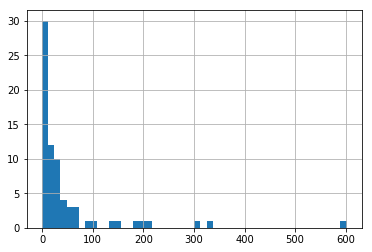

In [16]:
selected_government_units['percent_difference_to_verified_boundary'].hist(bins=50)

In [12]:
selected_government_units

,rank,count,distance_to_headquarters,id,name,percent_difference_to_verified_boundary,source,st_area
fc_id,,,,,,,,
77563,0,224,0.167419,2767,Rock,40.650866,countyorequivalent,0.206519
91743,0,274,0.098442,437,Umatilla,150.793415,countyorequivalent,0.965036
91031,0,6328,0.221692,1643,Douglas,1.596610,countyorequivalent,0.094484
86361,0,108,0.011367,29070,Mamaroneck,12.031685,minorcivildivision,0.003894
84012,0,290,0.237685,568,Monroe,37.498549,countyorequivalent,0.392711
83153,0,3739,0.018845,1520,Guilford,3.974897,countyorequivalent,0.170418
75808,0,413,0.029862,1039,Bristol,0.000000,countyorequivalent,0.003432
93595,0,5189,0.171517,568,Monroe,31.825562,countyorequivalent,0.392711
91180,0,119,0.518612,1234,Penobscot,182.271096,countyorequivalent,1.058752


In [13]:
df.set_index('fc_id')

,rank,count,distance_to_headquarters,id,name,percent_difference_to_verified_boundary,source,st_area
fc_id,,,,,,,,
77563,0,224,0.167419,2767,Rock,4.065087e+01,countyorequivalent,0.206519
77563,1,221,0.016071,36694,Beloit,8.064430e-02,minorcivildivision,0.005021
77563,2,221,0.016071,10073,Beloit,8.064430e-02,incorporatedplace,0.005021
77563,3,2,0.064325,36693,Beloit,2.526538e+00,minorcivildivision,0.007633
77563,4,1,0.092490,10477,Rockton,3.138908e+00,minorcivildivision,0.010606
77563,5,1,0.086570,7730,Roscoe,1.593975e+00,incorporatedplace,0.002945
77563,6,1,0.218898,2387,Winnebago,3.062792e+01,countyorequivalent,0.146907
91743,0,274,0.098442,437,Umatilla,1.507934e+02,countyorequivalent,0.965036
91743,1,270,0.194801,22144,Pendleton,4.035100e+01,minorcivildivision,0.262468


In [17]:
df.to_csv('./validated-boundary-vs-government-unit-incident-share.csv')

In [18]:
pd.read_csv('./validated-boundary-vs-government-unit-incident-share.csv')

,Unnamed: 0,rank,count,distance_to_headquarters,fc_id,id,name,percent_difference_to_verified_boundary,source,st_area
0,0,0,224,0.167419,77563,2767,Rock,4.065087e+01,countyorequivalent,0.206519
1,1,1,221,0.016071,77563,36694,Beloit,8.064430e-02,minorcivildivision,0.005021
2,2,2,221,0.016071,77563,10073,Beloit,8.064430e-02,incorporatedplace,0.005021
3,3,3,2,0.064325,77563,36693,Beloit,2.526538e+00,minorcivildivision,0.007633
4,4,4,1,0.092490,77563,10477,Rockton,3.138908e+00,minorcivildivision,0.010606
5,5,5,1,0.086570,77563,7730,Roscoe,1.593975e+00,incorporatedplace,0.002945
6,6,6,1,0.218898,77563,2387,Winnebago,3.062792e+01,countyorequivalent,0.146907
7,0,0,274,0.098442,91743,437,Umatilla,1.507934e+02,countyorequivalent,0.965036
8,1,1,270,0.194801,91743,22144,Pendleton,4.035100e+01,minorcivildivision,0.262468
9,2,2,241,0.021430,91743,11236,Pendleton,8.782634e-01,incorporatedplace,0.003222
